学习视频 https://www.bilibili.com/video/BV1K64y1Q7wu?spm_id_from=333.999.0.0

# Softmax回归+损失函数+图片分类数据集
对类别进行一位有效编码[one-hot]：

$y_i=1 or 0$

$O = XW + b$
* 值越大，负对数越小

## Softmax和交叉熵损失
* 推导见108页
* 交叉熵用来衡量两个概率的区别$H(p,q)=\sum_i-p_ilog(q_i)$
* 交叉熵越大，两个概率区别越大
* 交叉熵损失：

$l(y,\hat y) = -\sum_iy_ilog\hat {y_i} = -log\hat y_y$

——因为其中只有一个y是1其余都是0
* 其梯度是真是概率和预测概率的区别

$softmax(o)_i - y_i$

## 损失函数
* Huber's Robust Loss
$$ 
l(y,y') = \left\{
\begin{matrix}
|y-y'| - 1/2 & if|y-y'|>1\\
1/2(y-y')^2 & otherwise
\end{matrix}
\right.
$$
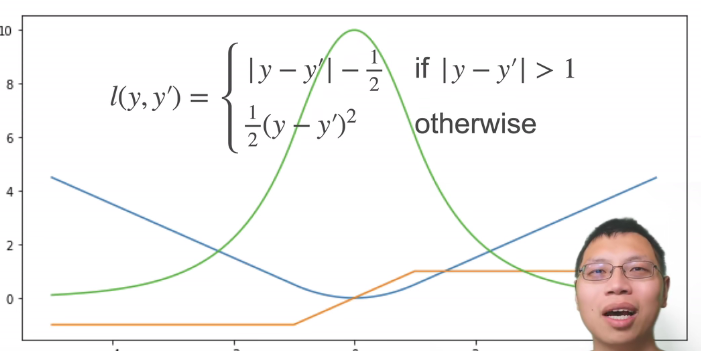

## 图像分类数据集
MNIST数据集是图像分类中广泛使用的数据集之一，但作为基准数据集过于简单。我们将使用类似但更复杂的Fashion-MNIST数据集

In [1]:
%matplotlib inline
import torch
import torchvision # 针对CV实现
from torch.utils import data # 方便读取数据以及小批量函数
from torchvision import transforms # 数据操作模组
from d2l import torch as d2l

d2l.use_svg_display() # 使用SVG显示图片，清晰度会高一些

In [2]:
'''
    通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式
    并处以255使得所有像素的数值均在0到1之间
'''

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                               train = True,
                                               transform = trans, # 要求的得到的数据格式是tensor不是图片
                                               download = True)

mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                               train = False,
                                               transform = trans,
                                               download = True)

len(mnist_train), len(mnist_test)

D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(60000, 10000)

In [3]:
'''
    第0个example，第0张图片
    黑白图片，rgb的channel数是1，长和宽都是28
    mnist_train[i]是(image, label)
'''
mnist_train[0][0].shape

torch.Size([1, 28, 28])

### <font color ='red'>定义两个可视化数据集的函数
笔记在书上

In [4]:
def get_fashion_mnist_labels(labels):
    '''返回Fashion-MNIST数据集的文本标签。'''
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 
                   'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles = None, scale = 1.5):
    '''Plot a list of images.'''
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize = figsize)
    axes = axes.flatten()
    
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        if titles:
            ax.set_title(titles[i])
    return axes

几个样本的图像及其相应的标签

<font color='red'>X,y的常用迭代器分批量赋值法
    
 `iter(data.DataLoader(_,batch_size = )))`</font>

In [5]:
a, b = torch.tensor([[1],[2],[3],[4]]), torch.tensor([[5],[6],[7],[8]])
c = data.TensorDataset(*(a,b))
d, e = next(iter(data.DataLoader(c, batch_size = 1)))
d, e

(tensor([[1]]), tensor([[5]]))

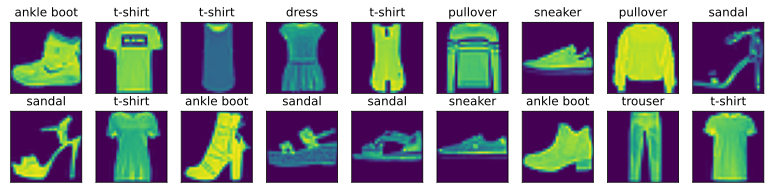

In [6]:
# 注意这里只是拿到第一个小批量
X, y = next(iter(data.DataLoader(mnist_train, batch_size = 18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles = get_fashion_mnist_labels(y));

In [7]:
X.shape

torch.Size([18, 1, 28, 28])

In [8]:
list_ = [1,2,3,4,5]
it = iter(list_)


In [9]:
next(it,'-1')

1

读取一个小批量数据，大小为`batch_size`

一般需要读取一个批量的数据的时间要比训练一批量耗时少

In [10]:
batch_size = 256

def get_dataloader_workers():
    '''使用4个进程来读取数据'''
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle = True, 
                            num_workers = get_dataloader_workers())

timer = d2l.Timer() # 用来测试运行时间

for X, y in train_iter:
    continue
    
    # 扫一遍数据
    
f'{timer.stop():.2f} sec'

'3.74 sec'

### 定义load_data_fashion_mnist函数

<font color = 'red'>`trans.inset`没看懂

In [11]:
def load_data_fashion_mnist(batch_size, resize = None):
    '''下载Fashion-MNIST数据集，然后将其加载到内存中。'''
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize)) 
        # tansforms.Resize(resize)让图片变得更大？？
    
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='../data',
                                                   train = True, 
                                                   transform = trans, 
                                                   download = True)
    mnist_train = torchvision.datasets.FashionMNIST(root='../data',
                                               train = False, 
                                               transform = trans, 
                                               download = True)
    
    return (data.DataLoader(mnist_train, batch_size, shuffle = True, 
                           num_workers = get_dataloader_workers()),
           data.DataLoader(mnist_test, batch_size, shuffle = False, 
                           num_workers = get_dataloader_workers()))

通过指定resize来测试图像调整大小功能

In [12]:
train_iter, test_iter = load_data_fashion_mnist(32, resize = 64)
for X, y in train_iter:
    print(X.shape,X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## softmax回归的从零开始实现

In [13]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
'''
    生成迭代器
'''

'\n    生成迭代器\n'

展平图像为向量，输出是10个类别

In [14]:
num_inputs = 784 # softmax回归需要输入向量，所以需要把图片拉长【这样直接拉长会损失很多空间信息——（CNN）】 28*28
num_outputs = 10 # 10类，输出为10

w = torch.normal(0, 0.01, size = (num_inputs, num_outputs),requires_grad = True)
b = torch.zeros(num_outputs, requires_grad = True)

# 随机生成真实参数
# 因为有10个输出，所以应该有10组参数

给定一个矩阵`X`，我们可以对所有元素求和

In [15]:
X = torch.tensor([[1.0, 2, 3], [4.0, 5, 6]])
X.sum(0, keepdim = True).shape, X.sum(1, keepdim = True).shape

(torch.Size([1, 3]), torch.Size([2, 1]))

### 实现softmax
$
softmax(X)_{ij} = \frac{exp(X{ij})}{\sum_kexp(X{i,k})} 
$

In [16]:
def softmax(X):
    X_exp = torch.exp(X) # 指数运算——torch.exp(X)
    partition = X_exp.sum(1, keepdim = True) # partition是分母的意思，keepdim=True是为了广播机制？
    return X_exp / partition # 这里应用了广播机制[一维维数是1，其他维数要对上]

In [17]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1863, 0.4335, 0.2266, 0.1021, 0.0515],
         [0.2929, 0.0733, 0.4338, 0.1506, 0.0495]]),
 tensor([1., 1.]))

实现softmax回归模型

In [18]:
def net(X):
    '''
        输入图形矩阵X
    '''
    return softmax(torch.matmul(X.reshape(-1, w.shape[0]), w) + b )

创建一个数据`y_hat`，其中包含2个样本在3个类别的预测概率，使用`y`作为`y_hat`中概率的索引。

In [19]:
'''
这里要记住，中括号[]是取轴
'''
y = torch.tensor([0, 2]) # 第一个样本的真实类别为0，第二个样本的真实类别为2
y_hat = torch.tensor([[0.1, 0.3, 0.6],[0.3, 0.2, 0.5]])
y_hat[[0, 1], y] # [0, 1]是取axis，就是外面的行

# y_hat[[0, 1], y]表示的是预测为正确类别的概率


tensor([0.1000, 0.5000])

实现交叉熵损失函数

<font color='red'>最小化负对数似然函数 等价于 最小化交叉熵损失函数</font>

$\hat {y} = softmax(o)$

$y^{(i)}$是样本$i$的 `one-hot` 标签向量,$\hat {y}^{(i)}$是第$i$个样本对应的softmax预测值。

$$l(y,\hat y) = -\sum_iy_ilog\hat {y_i} = -log\hat y_y$$
$$l(y,\hat y) = -logP(Y|X)$$
* 其中因为是one-hot向量，所以交叉熵求和之后只剩下对应标签项的预测条件概率密度

In [20]:
'''
    注意有：torch.log
    y_hat[range(len(y_hat)), y]——range(len(y_hat))样本[行]标号以及`y`对应的概率
    * 注意这里的y代表的是样本所属类别，如果4，则为第4类。在上述表达式中就是取出y_hat的第四个拟合值
    与交叉熵乘一堆one-hot向量达到一样的效果——取出样本真实类别对应的拟合概率
'''
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

将预测类别与真实`y`元素进行比较

定义准确率

In [21]:
def accuracy(y_hat, y):
    '''计算预测正确的总数'''
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        # len(y_hat.shape) > 1 代表维数＞1
        # y_hat.shape[1] > 1 代表第二维（列）、种类数 > 1
        
        y_hat = y_hat.argmax(axis = 1)
        # 输出每一个样本对应的预测值最高的类别索引
        
    cmp = y_hat.type(y.dtype) == y
    # 输出每个样本对应的True和False列表
    # True和False和1,0对应，实则输出一个对应样本是否准确的指示向量
    # 转换为与y同一个数据类型后即可全部相加则为预测正确的总数
    # 实际上python里面Bool类型也能直接加出来数字的
    
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

这样我们可以评估任意模型`net`的准确率

In [22]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度。"""
    '''
    isinstance()用来判断对象是否是一种已知类型。
    net.eval() # 将模型设置为评估模式——不计算梯度，只做一个forward path
    Accumulator() 累加器的概念在后面
    .numel() 元素总数——y.numel()就是对应样本数【因为y是一个所有样本对应类别的向量】
    '''
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    
    metric = Accumulator(2) # 正确预测数、预测总数
    # 创造一个2维的浮点数零向量
    # metric为Accumulator的一个实例
    
    
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
        
    return metric[0] / metric[1]

<font color = 'red'>`Accumulator`的实现（不断做加法）</font>
* 创建了2个变量，用于分别存储正确预测的数量和预测的总数量

In [23]:
class Accumulator:
    """
        在n个变量上累加。
        *表示接受一个tuple类型（元组）,往上面套一个()
        **表示接受一个dict类型（字典）
    
    """
    def __init__(self, n):
        self.data = [0.0] * n # 创建一个n维的浮点数0向量
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]
    
evaluate_accuracy(net, test_iter)

0.1573

In [26]:
data

[2.0, 3.0]

In [27]:
def add(data, *args):
    data = [a + float(b) for a, b in zip(data,args)]
    return data

In [28]:
add(data, *(2,3))

[4.0, 6.0]

In [29]:
for a,b in zip(2,2):
    print(a)

TypeError: 'int' object is not iterable

In [ ]:
for a in zip(,*(1,2)):
    print(a)

In [35]:
def test(*args):
    print(args)
    print(*args)
    
def test2(args):
    print(args)
    print(*args)

In [36]:
test((1,2))
test2((1,2))

((1, 2),)
(1, 2)
(1, 2)
1 2


In [37]:
test(1,2)
test2(1,2)

(1, 2)
1 2


TypeError: test2() takes 1 positional argument but 2 were given